<a href="https://colab.research.google.com/github/tabasy/nlp_notebooks/blob/master/explain_mlm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prepare Libs

In [ ]:
# @title install libs

!pip install transformers

In [2]:
# @title import libs

from transformers import AutoModelForMaskedLM, AutoTokenizer, FillMaskPipeline

import torch
import matplotlib.pyplot as plt

# Load Models, Define Funcs

* You can load multiple models by running the cell below  multiple times

In [3]:
# @title load models
models = models if 'models' in dir() else {}
tokenizers = tokenizers if 'tokenizers' in dir() else {}
pipelines = pipelines if 'pipelines' in dir() else {}

model_name = "roberta-large" #@param ["xlm-roberta-large", "bert-base-uncased", "bert-large-uncased", "bert-base-cased", "bert-large-cased", "roberta-base", "roberta-large", "bert-base-multilingual-uncased", "HooshvareLab/bert-base-parsbert-uncased"]

if model_name not in models:
  tokenizers[model_name] = AutoTokenizer.from_pretrained(model_name)
  models[model_name] = AutoModelForMaskedLM.from_pretrained(model_name)
  pipelines[model_name] = FillMaskPipeline(model=models[model_name],
                                          tokenizer=tokenizers[model_name],
                                          topk=10, device=0)
  
print(list(models.keys()))

Some weights of RobertaForMaskedLM were not initialized from the model checkpoint at roberta-large and are newly initialized: ['lm_head.decoder.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


['roberta-large']


In [4]:
# @title fill mask

def fill_mask(text, k, return_full_text=True, model_name=None):

  model_name = model_name or list(models.keys())[0]
  tokenizer = tokenizers[model_name]
  pipeline = pipelines[model_name]

  text = text.replace('*', tokenizer.mask_token)
  topk_tokens = pipeline(text)[:k]

  for output in topk_tokens:
    if return_full_text:
      yield output['sequence'].replace(tokenizer.cls_token, '').replace(tokenizer.sep_token, '')
    else:
      yield output['score'], output['token'], output['token_str'].replace('Ġ', '')
  

In [5]:
# @title remove word
def remove_one_word(text, model_name=None, replace=False, return_tokens=False):
  removed_sents = []

  model_name = model_name or list(models.keys())[0]
  tokenizer = tokenizers[model_name]

  text = text.replace('*', tokenizer.mask_token)
  tokens = tokenizer.tokenize(text)
  
  for i, token in enumerate(tokens):
    replacement = [replace] if replace else [] 
    if token == tokenizer.mask_token:
      replacement = [tokenizer.mask_token]
    new_sent = tokens[:i] + replacement + tokens[i+1:]
    if not return_tokens:
        new_sent = tokenizer.convert_tokens_to_string(new_sent)
    removed_sents.append(new_sent)
  
  return removed_sents

In [6]:
# @title token importance
def get_token_importance(text, target_word, model_name=None,
                          separate_sent=False):
  model_name = model_name or list(models.keys())[0]
  tokenizer = tokenizers[model_name]
  pipeline = pipelines[model_name]

  target_word = ' ' + target_word.strip()
  text = text.replace('*', tokenizer.mask_token)
  tokens = tokenizer.tokenize(text)
  tokens = [token.replace('Ġ', '') for token in tokens]
  fixed_idx = tokens.index(tokenizer.mask_token)
  tokens[fixed_idx] = target_word

  removed_sents = remove_one_word(text, replace=False, model_name=model_name)
  mask_preds = pipeline(removed_sents, targets=target_word)

  probs = [pred[0]['score'] for pred in mask_preds]
  importances = [probs[fixed_idx]-prob for prob in probs]

  return importances, tokens

# get_token_importance('i am a black *.', 'man', model_name=model_name)

In [7]:
# @title visualize importance
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as clr
from pylab import rcParams

from IPython.display import HTML

def visualize_attention(sentences, score_lists, color_maps='RdYlGn', rtl=False,
                        alpha=0.5, font_size=14, token_sep=' ', sentence_sep='<br/><br/>'):

  if type(color_maps) is str:
    color_maps = [color_maps] * len(sentences)

  span_sentences, style_sentences = [], []

  for s, tokens in enumerate(sentences):

    scores = score_lists[s]
    cmap = cm.get_cmap(color_maps[s])
    
    max_value = max(abs(min(scores)), abs(max(scores)))
    normer = clr.Normalize(vmin=-max_value/alpha, vmax=max_value/alpha)
    colors = [clr.to_hex(cmap(normer(x))) for x in scores]

    if len(tokens) != len(colors):
        raise ValueError("number of tokens and colors don't match")

    style_elems, span_elems = [], []
    for i in range(len(tokens)):
        style_elems.append(f'.c{s}-{i} {{ background-color: {colors[i]}; }}')
        span_elems.append(f'<span class="c{s}-{i}">{tokens[i]} </span>')

    span_sentences.append(token_sep.join(span_elems))
    style_sentences.append(' '.join(style_elems))
    text_dir = 'rtl' if rtl else 'ltr'

  return HTML(f"""<html><head><link href="https://fonts.googleapis.com/css?family=Roboto+Mono&display=swap" rel="stylesheet">
               <style>span {{ font-family: "Roboto Mono", monospace; font-size: {font_size}px; padding: 2px}} {' '.join(style_sentences)}</style>
               </head><body><p dir="{text_dir}">{sentence_sep.join(span_sentences)}</p></body></html>""")

# Explain Prediction

* A simple method proposed by TextFooler paper (Jin et al. 2019) to measure the influence of each context word towards a prediction (a target word in this case).
* As the name TextFooler implies, this method is used to generate black-box adversarial examples which make a drastic change in model prediction with minimum variation (perturbation) in the input text.
* The change in probability of target word caused by removing each individual token, is considered as its influence/importance.
* The influence can be negative. This meaning if we remove that token, the model will be more confident about the target word.
* **This method is a black-box approximation of gradient-based feature attribution. USE WITH YOUR OWN RISK! :)**


## #1

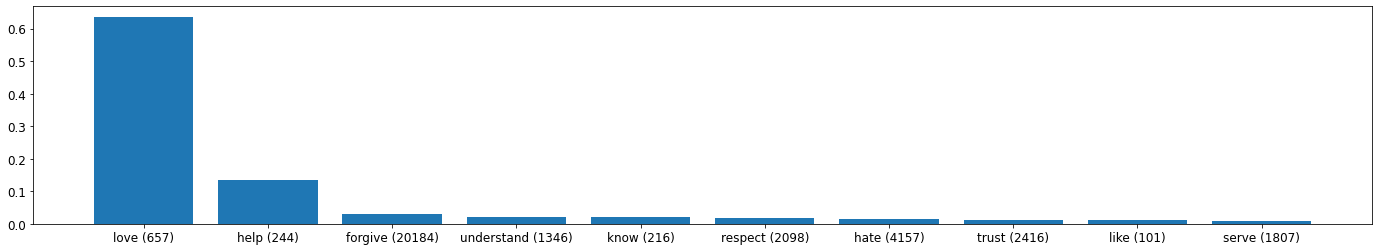

In [8]:
model_name = "roberta-large" #@param ["bert-base-uncased", "bert-large-uncased", "bert-base-cased", "bert-large-cased", "roberta-base", "roberta-large", "bert-base-multilingual-uncased", "HooshvareLab/bert-base-parsbert-uncased"]
text = "Jesus, the prophet of God, wanted the people to * each other." #@param {type:"string"}
prefix = "" #@param {type:"string"}
postfix = "" #@param {type:"string"}

top_k = 10 #@param {type:"integer"}

font_size = 12 #@param {type:"integer"}

print_full_text = False #@param {type:"boolean"}
probs, words = [], []
plt.rcParams['figure.figsize'] = [24, 4]
plt.rcParams['font.size'] = font_size

full_text = f'{prefix} {text} {postfix}'.strip()
top_k_words = list(fill_mask(full_text, top_k, model_name=model_name, return_full_text=print_full_text))
for output in top_k_words:
  if print_full_text:
    print(output)
  else:
    probs.append(output[0])
    words.append(f'{output[2]} ({output[1]})')

if not print_full_text:
  plt.bar(words, probs)
  plt.show()

In [9]:
# @title visualize importance

target_word = ""#@param {type:"string"}
colormap = "bwr_r" #@param ["RdYlGn", "bwr_r"]
alpha = 0.8 #@param {type:"number"}
disable_prefix_postfix = True #@param {type:"boolean"}
right_to_left = False #@param {type:"boolean"}

if target_word.strip() == '':
  target_word = top_k_words[0][2]

importances, tokens = get_token_importance(full_text, target_word, model_name=model_name)
tokenizer = tokenizers[model_name]

if disable_prefix_postfix and len(prefix.strip()) > 0:
  prefix_tokens = tokenizer.tokenize(prefix.replace('*', tokenizer.mask_token))
  for i in range(len(prefix_tokens)):
    importances[i] = 0

if disable_prefix_postfix and len(postfix.strip()) > 0:
  postfix_tokens = tokenizer.tokenize(postfix.replace('*', tokenizer.mask_token))
  for i in range(len(postfix_tokens)):
    importances[-i-1] = 0

visualize_attention([tokens], [importances], color_maps=colormap, rtl=right_to_left, alpha=alpha)

## #2

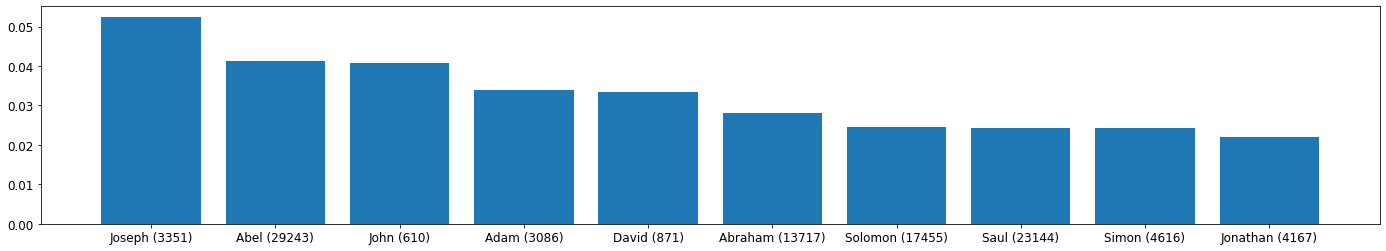

In [10]:
model_name = "roberta-large" #@param ["bert-base-uncased", "bert-large-uncased", "bert-base-cased", "bert-large-cased", "roberta-base", "roberta-large", "bert-base-multilingual-uncased", "HooshvareLab/bert-base-parsbert-uncased"]
text = "Then he turned away from them, and said, \"O my bitterness for my son, *.\" And his eyes turned white from sorrow, and he became depressed." #@param {type:"string"}
prefix = "" #@param {type:"string"}
postfix = "" #@param {type:"string"}

top_k = 10 #@param {type:"integer"}

font_size = 12 #@param {type:"integer"}

print_full_text = False #@param {type:"boolean"}
probs, words = [], []
plt.rcParams['figure.figsize'] = [24, 4]
plt.rcParams['font.size'] = font_size

full_text = f'{prefix} {text} {postfix}'.strip()
top_k_words = list(fill_mask(full_text, top_k, model_name=model_name, return_full_text=print_full_text))
for output in top_k_words:
  if print_full_text:
    print(output)
  else:
    probs.append(output[0])
    words.append(f'{output[2]} ({output[1]})')

if not print_full_text:
  plt.bar(words, probs)
  plt.show()

In [11]:
# @title visualize importance

target_word = "Joseph"#@param {type:"string"}
colormap = "RdYlGn" #@param ["RdYlGn", "bwr_r"]
alpha = 0.8 #@param {type:"number"}
disable_prefix_postfix = False #@param {type:"boolean"}
right_to_left = False #@param {type:"boolean"}

if target_word.strip() == '':
  target_word = top_k_words[0][2]

importances, tokens = get_token_importance(full_text, target_word, model_name=model_name)
tokenizer = tokenizers[model_name]

if disable_prefix_postfix and len(prefix.strip()) > 0:
  prefix_tokens = tokenizer.tokenize(prefix.replace('*', tokenizer.mask_token))
  for i in range(len(prefix_tokens)):
    importances[i] = 0

if disable_prefix_postfix and len(postfix.strip()) > 0:
  postfix_tokens = tokenizer.tokenize(postfix.replace('*', tokenizer.mask_token))
  for i in range(len(postfix_tokens)):
    importances[-i-1] = 0

visualize_attention([tokens], [importances], color_maps=colormap, rtl=right_to_left, alpha=alpha)